# NLP with Disaster Tweets

# Introduction

Kaggle competition: https://www.kaggle.com/competitions/nlp-getting-started/

With Twitter's rapid news availability and widespread use, it has become a useful tool in communicating emergencies. However, it is important to differentiate between disaster tweets and non-disaster tweets when Twitter is deciding what comes up on people's feeds. The ability for an algorithm to make this distinction is important, and is a fun natural language processing challenge for young data scientists.

# Setup

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional, LSTM, GlobalMaxPool1D, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2

In [2]:
path = "/Users/clairerobbins/Documents/MS-DS CU Boulder/Introduction to Deep Learning/NLP with Disaster Tweets/nlp-getting-started/" 
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# EDA

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
print('There are {} rows and {} columns in train.'.format(train.shape[0],train.shape[1]))

There are 7613 rows and 5 columns in train.


In [7]:
col_names = list(train.columns)
dictionary = {}
for i in range(len(col_names)):
    dictionary[col_names[i]] = np.round((train.isnull().sum()[i]/len(train))*100,2)
dictionary

{'id': 0.0, 'keyword': 0.8, 'location': 33.27, 'text': 0.0, 'target': 0.0}

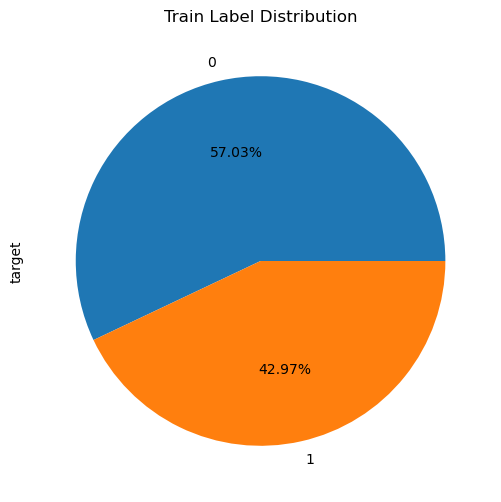

In [8]:
train['target'].value_counts().plot(figsize=(6,6),kind='pie',autopct='%.2f%%')
plt.title('Train Label Distribution')
plt.show()

In [9]:
train_updated = train.copy()
train_updated['text_split'] = [i.split() for i in train_updated['text']]
train_updated['text_length'] = [len(i) for i in train_updated['text_split']]

In [10]:
train_updated

,id,keyword,location,text,target,text_split,text_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[Our, Deeds, are, the, Reason, of, this, #eart...",13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[Forest, fire, near, La, Ronge, Sask., Canada]",7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[All, residents, asked, to, 'shelter, in, plac...",22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, #wildfires, evacuati...",8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[Just, got, sent, this, photo, from, Ruby, #Al...",16
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,"[Two, giant, cranes, holding, a, bridge, colla...",11
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,"[@aria_ahrary, @TheTawniest, The, out, of, con...",20
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,"[M1.94, [01:04, UTC]?5km, S, of, Volcano, Hawa...",8
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,"[Police, investigating, after, an, e-bike, col...",19


In [11]:
disaster = train_updated[train_updated['target']==1]['text_length'].values
not_disaster = train_updated[train_updated['target']==0]['text_length'].values

(array([100., 345., 539., 690., 684., 728., 585., 416., 204.,  51.]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 [<matplotlib.patches.Polygon at 0x16a1a64d0>])

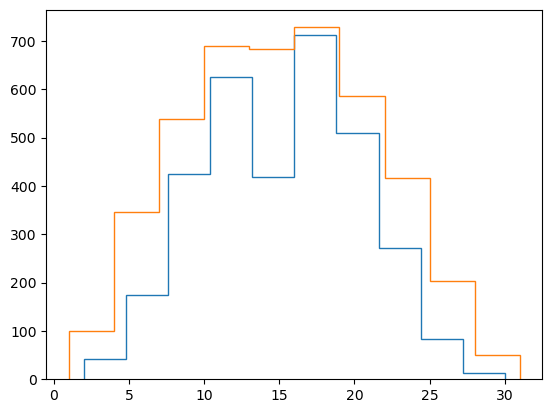

In [12]:
plt.hist(disaster, histtype='step')
plt.hist(not_disaster, histtype='step')

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [14]:
print('There are {} rows and {} columns in train.'.format(test.shape[0],test.shape[1]))

There are 3263 rows and 4 columns in train.


In [15]:
col_names = list(test.columns)
dictionary = {}
for i in range(len(col_names)):
    dictionary[col_names[i]] = np.round((test.isnull().sum()[i]/len(test))*100,2)
dictionary

{'id': 0.0, 'keyword': 0.8, 'location': 33.86, 'text': 0.0}

## Data Preprocessing & Data Cleaning

In [16]:
def clean(text):
    # get rid of stopwords
    stop_words = set(stopwords.words('english'))
    # get rid of punctuation
    punctuation_chars = set(punctuation)
    # reduce words to simplest form
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    clean_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalpha() and token.lower() not in stop_words and token not in punctuation_chars]
    cleaned_text = " ".join(clean_tokens)
    return cleaned_text

# Apply preprocessing to the 'text' column in the 'train' and 'test' DataFrames
train['cleaned_text'] = train['text'].apply(lambda x: clean(x))
test['cleaned_text'] = test['text'].apply(lambda x: clean(x))

In [67]:
# Example data and labels (replace with your actual data)
texts = train['cleaned_text']
target = train['target']  # 1: Disastrous, 0: Not Disastrous

# Split the data into train and validation sets
train_texts, val_texts, train_target, val_target = train_test_split(texts, target, test_size=0.2, random_state=42)

# Tokenize and generate padded sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

vocab_size = len(tokenizer.word_index) + 1
max_sequence_length = max([len(text.split()) for text in train_texts])

train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

padded_train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
padded_val_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post')

## Model Development & Architecture

In my initial set up, I chose to split my train data into train & validation data, to get a sense of how the model is performing in real time. I began with a high number of epochs (50) but quickly minimized due to overfitting. 

In [55]:
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.5))  # Adding dropout layer
model.add(GRU(64))
model.add(Dropout(0.5))  # Adding dropout layer
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
model.fit(padded_train_sequences, train_target, epochs=10, batch_size=32, 
          validation_data=(padded_val_sequences, val_target))

Epoch 1/10
191/191 [==============================] - 2s 12ms/step - loss: 0.0271 - accuracy: 0.9842 - val_loss: 1.7429 - val_accuracy: 0.7360
Epoch 2/10
191/191 [==============================] - 2s 12ms/step - loss: 0.0266 - accuracy: 0.9852 - val_loss: 1.8153 - val_accuracy: 0.7420
Epoch 3/10
191/191 [==============================] - 2s 12ms/step - loss: 0.0252 - accuracy: 0.9857 - val_loss: 1.9683 - val_accuracy: 0.7511
Epoch 4/10
191/191 [==============================] - 2s 12ms/step - loss: 0.0254 - accuracy: 0.9859 - val_loss: 1.8911 - val_accuracy: 0.7452
Epoch 5/10
191/191 [==============================] - 2s 12ms/step - loss: 0.0394 - accuracy: 0.9826 - val_loss: 1.3621 - val_accuracy: 0.7433
Epoch 6/10
191/191 [==============================] - 2s 12ms/step - loss: 0.0319 - accuracy: 0.9836 - val_loss: 1.4949 - val_accuracy: 0.7557
Epoch 7/10
191/191 [==============================] - 2s 12ms/step - loss: 0.0328 - accuracy: 0.9849 - val_loss: 1.4821 - val_accuracy: 0.7446

I made the following changes in an attempt to address overfitting:

1. Used a more simple model with only two GRU layers
2. Added dropout layers after each GRU layer with a dropout rate of 0.5 to regularize by randomly dropping connections during training
3. Reduced the number of training epochs to 10 because the model began overfitting with a higher number of epochs
4. Attempted to use early stopping, but ended up with a worse validation accuracy and chose to eliminate

## Predictions

In [70]:
test_texts = test['cleaned_text']

test_tokenizer = Tokenizer()
tokenizer.fit_on_texts(test_texts)

vocab_size = len(tokenizer.word_index) + 1

test_sequences = tokenizer.texts_to_sequences(test_texts)  # Replace test_texts with your actual test data

# Pad the test sequences to match max_sequence_length used during training
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

# Make predictions
predictions = model.predict(padded_test_sequences)

102/102 [==============================] - 0s 2ms/step


In [72]:
# convert prediction percentages to binary classification
final_predictions = []
for i in predictions:
    if i > 0.5:
        final_predictions.append(1)
    else:
        final_predictions.append(0)

In [75]:
# generate submission file
submission = pd.DataFrame({'id': test['id'], 'target': final_predictions})
submission.to_csv('submission.csv')

## Conclusion

My model struggled with overfitting, and despite many attempts to mitigate I could not overcome this overfitting issue. I tried various layers and dropout values, but could not fully optimize. However, I learned a lot about how the hyperparameters affect other aspects of the model, and intend to continue my efforts on this project outside of this course.